# Multimodal Search through Image and Text
### Use OpenAI's Clip neural network to embed images and text for vector similarity search
![picture](https://cdn.sanity.io/images/vr8gru94/production/539716ea1571e459908c1fdc5a898fea239d8243-2803x1672.png)

This example is aimed to guide you through using OpenAI's Clip model to embed a dataset, store it into LanceDB, and search for relevant texts/images. The `"multimodal_clip"` example also uses the same model.

First, let's **install** and **import** some dependencies. (These are all in the requirements.txt file in this example folder and the root folder.)

In [ ]:
%pip install pillow datasets lancedb
%pip install git+https://github.com/openai/CLIP.git

In [27]:
from datasets import load_dataset
from enum import Enum
import lancedb
from tqdm import tqdm
from IPython.display import display

We will be using this HuggingFace dataset [here](https://huggingface.co/datasets/CVdatasets/ImageNet15_animals_unbalanced_aug1), which contain pictures of various types of dogs and other animals.

### Load the dataset

In [28]:
dataset = load_dataset("CVdatasets/ImageNet15_animals_unbalanced_aug1", split="train")

Unfortunately, this dataset only labels the images with numbers, so we can create an enum to map the numbers to the actual class names. The names are provided on the HuggingFace dataset link.

### Enum class

In [29]:
class Animal(Enum):
    italian_greyhound = 0
    coyote = 1
    beagle = 2
    rottweiler = 3
    hyena = 4
    greater_swiss_mountain_dog = 5
    Triceratops = 6
    french_bulldog = 7
    red_wolf = 8
    egyption_cat = 9
    chihuahua = 10
    irish_terrier = 11
    tiger_cat = 12
    white_wolf = 13
    timber_wolf = 14


print(dataset[0])
print(Animal(dataset[0]["labels"]).name)

{'labels': 0, 'img': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x339 at 0x7BF5108F85B0>, 'is_generated': False}
italian_greyhound


We can now load the pretrained model `ViT-B/32` from Clip, using either `cuda` or `cpu` depending on which torch version you are using.

In [30]:
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

Creating the **image embedding function** here. We want the embeddings to be a standard list, so we can convert the Tensor array to Numpy array to List.

In [31]:
def embed(img):
    image = preprocess(img).unsqueeze(0).to(device)
    embs = model.encode_image(image)
    return embs.detach().cpu().numpy()[0].tolist()

In [32]:
len(embed(dataset[0]["img"]))

512

Time to connect to the LanceDB table! you can create a PyArrow schema to initialize an empty table, like this:

```python
schema = pa.schema(
  [
      pa.field("vector", pa.list_(pa.float32(), 512)),
      pa.field("id", pa.int32()),
      pa.field("label", pa.int32()),
  ])
tbl = db.create_table("animal_images", schema=schema)
```

After creating the table, we want to prepare all the data to add to the table. We can first append all the data as a dictionary to an array.

In [36]:
import pyarrow as pa

db = lancedb.connect("./data/tables")
schema = pa.schema(
    [
        pa.field("vector", pa.list_(pa.float32(), 512)),
        pa.field("id", pa.int32()),
        pa.field("label", pa.int32()),
    ]
)
tbl = db.create_table("animal_images", schema=schema, mode="overwrite")

data = []
for i in tqdm(range(1, len(dataset))):
    data.append(
        {"vector": embed(dataset[i]["img"]), "id": i, "label": dataset[i]["labels"]}
    )

100%|██████████| 3704/3704 [01:22<00:00, 44.96it/s]


Then, we can split it up into batches of 50, to then embed the image and add to the table. This will take around 10 minutes, because embedding 3.7k images can take a while.

In [38]:
tbl.add(data)
tbl.to_pandas()

vector    id  label
0     [0.03756714, 0.0793457, -0.09222412, 0.4516601...     1      0
1     [0.094055176, 0.032928467, -0.17419434, 0.6601...     2      0
2     [-0.22644043, 0.36987305, -0.10144043, 0.76953...     3      0
3     [-0.21899414, 0.44091797, -0.057800293, 0.7006...     4      0
4     [0.2199707, 0.21411133, -0.12646484, 0.1096191...     5      0
...                                                 ...   ...    ...
3699  [-0.2697754, -0.01878357, -0.068847656, 0.1434...  3700     14
3700  [-0.35766602, -0.23254395, 0.10205078, 0.20275...  3701     14
3701  [0.006214142, -0.04046631, -0.0034446716, 0.28...  3702     14
3702  [-0.11273193, -0.20593262, -0.19836426, 0.2897...  3703     14
3703  [-0.21618652, -0.18457031, -0.15441895, 0.0853...  3704     14

[3704 rows x 3 columns]

The table looks good! We can now start testing the image search. First, load the validation split of the dataset.

In [39]:
test = load_dataset("CVdatasets/ImageNet15_animals_unbalanced_aug1", split="validation")

1439
{'labels': 1, 'img': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7BF512CB8A30>, 'is_generated': False}
coyote


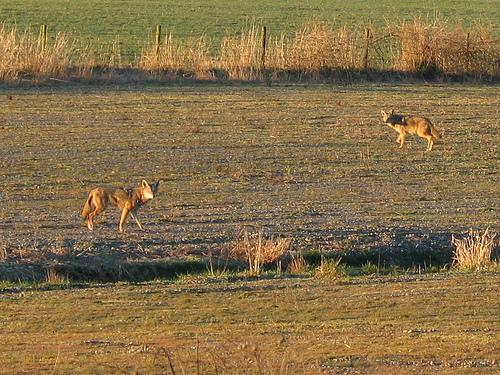

In [44]:
print(len(test))
print(test[100])
print(Animal(test[100]["labels"]).name)
test[100]["img"]

This is how we can search the table: by embedding the image we want, calling the search function, and retuning a Pandas DataFrame.

The purpose of storing the ID is to call the original dataset back and displaying the image. Another way could be to store the image as bytes in the database, but this would make the database much larger.

In [45]:
embs = embed(test[100]["img"])

res = tbl.search(embs).limit(1).to_df()
res

vector    id  label  _distance
0  [-0.07678223, -0.31567383, 0.07366943, -0.0075...  1532      4  31.333738

And getting the id of the first result:

In [46]:
print(Animal(res["label"][0]).name)
id = int(res["id"][0])
id

hyena


1532

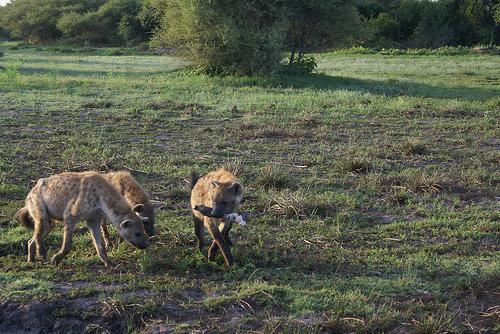

In [47]:
dataset[id]["img"]

Nice! It correctly identified another italian greyhound! Now, to everything into a function:

In [48]:
def image_search(id):
    print(Animal(test[id]["labels"]).name)
    display(test[id]["img"])

    res = tbl.search(embed(test[id]["img"])).limit(5).to_df()
    print(res)
    for i in range(5):
        print(Animal(res["label"][i]).name)
        data_id = int(res["id"][i])
        display(dataset[data_id]["img"])

tiger_cat


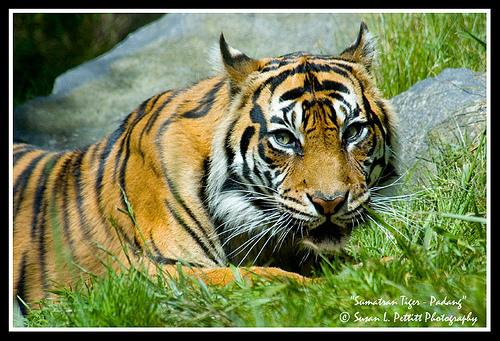

                                              vector    id  label  _distance
0  [-0.049102783, -0.21655273, -0.12780762, -0.07...  3132     12  23.221460
1  [0.2241211, -0.2836914, -0.18920898, -0.073059...  3315     12  23.790337
2  [-0.12030029, -0.2290039, -0.15270996, -0.3728...  3163     12  24.347380
3  [-0.042541504, -0.36791992, -0.17285156, -0.22...  3174     12  25.933134
4  [0.1373291, -0.22399902, -0.06616211, -0.07781...  2987     12  26.332230
tiger_cat


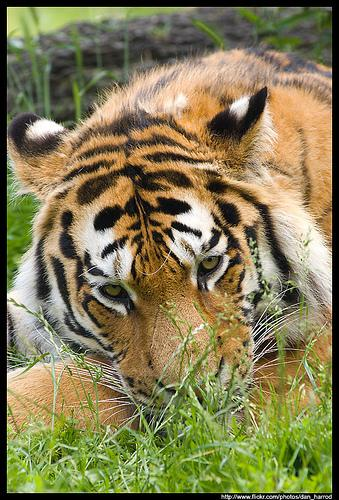

tiger_cat


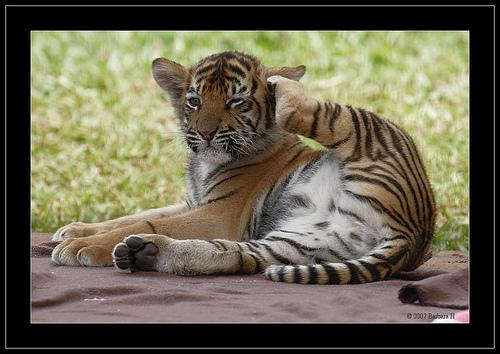

tiger_cat


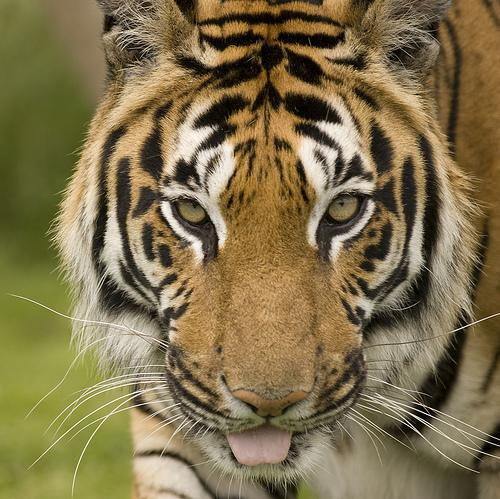

tiger_cat


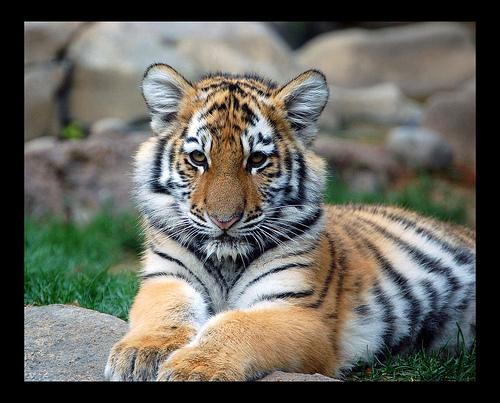

tiger_cat


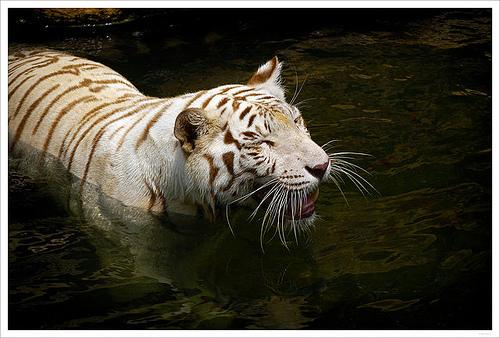

In [50]:
image_search(1200)

Great, we have finished the image search! To begin the multimodal text search, we can create a similar embedding function, but using Clip's `encode_text` function instead of `encode_image`.

In [21]:
def embed_txt(txt):
    text = clip.tokenize([txt]).to(device)
    embs = model.encode_text(text)
    return embs.detach().cpu().numpy()[0].tolist()

In [22]:
len(embed_txt("Black and white dog"))

512

We perform the same search here by calling our just-made text embedder.

In [53]:
res = tbl.search(embed_txt("a french_bulldog ")).limit(1).to_df()
res

vector    id  label   _distance
0  [-0.13562012, 0.29614258, -0.27124023, -0.1573...  2790     11  120.330276

irish_terrier


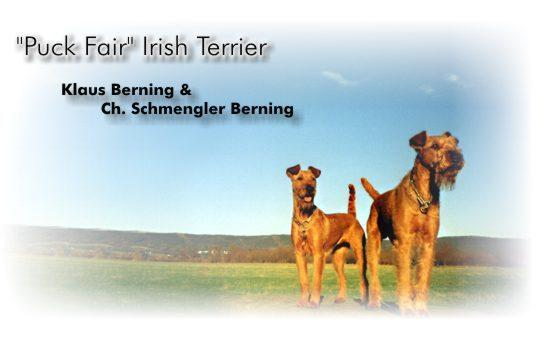

In [54]:
print(Animal(res["label"][0]).name)
data_id = int(res["id"][0])
display(dataset[data_id]["img"])

### Combining everything into a function once again:

In [55]:
def text_search(text):
    res = tbl.search(embed_txt(text)).limit(5).to_df()
    print(res)
    for i in range(len(res)):
        print(Animal(res["label"][i]).name)
        data_id = int(res["id"][i])
        display(dataset[data_id]["img"])

                                              vector    id  label   _distance
0  [-0.6616211, 0.1842041, -0.15319824, 0.2392578...  3532     13  119.904297
1  [-0.19128418, -0.4519043, -0.05456543, 0.12890...  3581     14  120.694580
2  [-0.06365967, -0.34350586, -0.095214844, 0.590...  3434     13  124.063377
3  [0.009864807, 0.037109375, -0.14575195, -0.042...   981      3  130.515411
4  [-0.18713379, 0.18688965, -0.2310791, 0.409179...  3487     13  131.742676
white_wolf


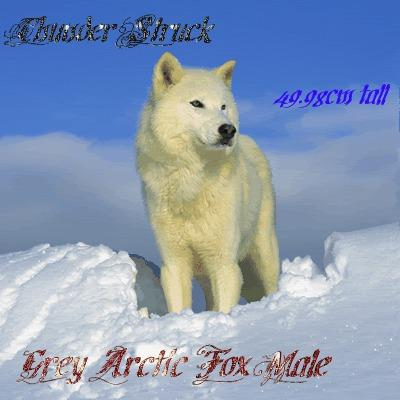

timber_wolf


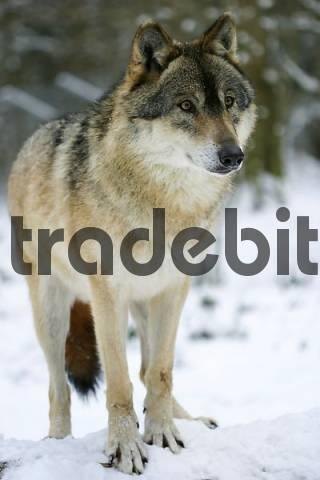

white_wolf


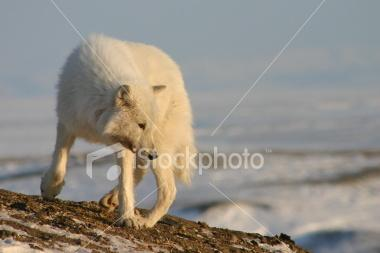

rottweiler


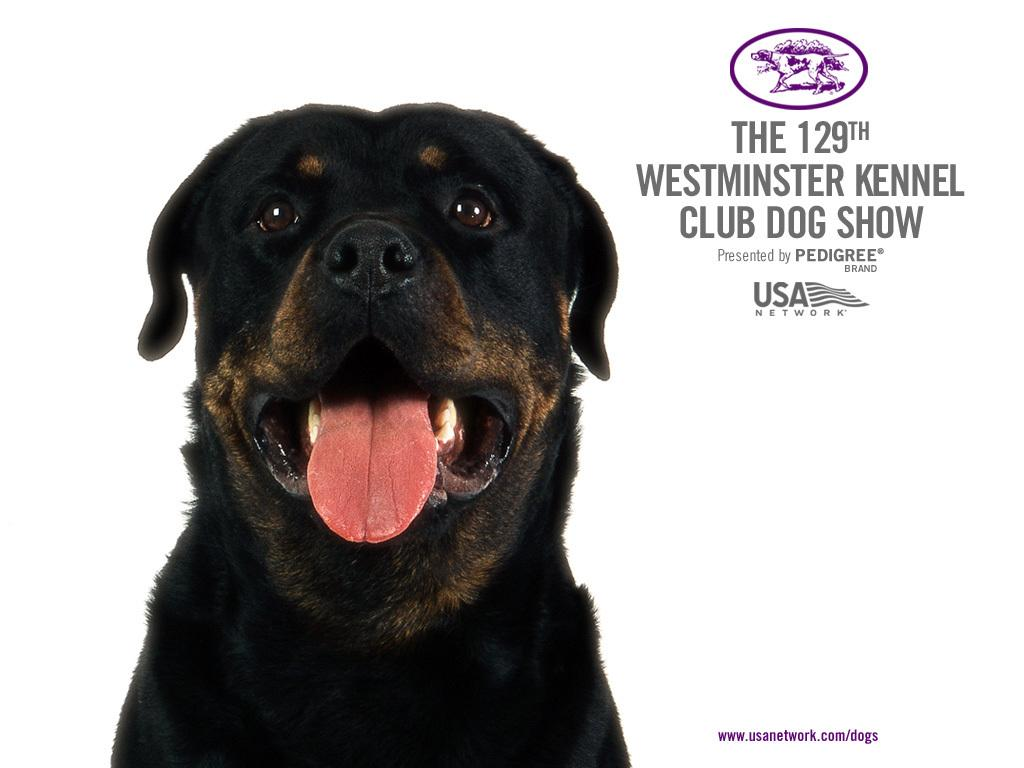

white_wolf


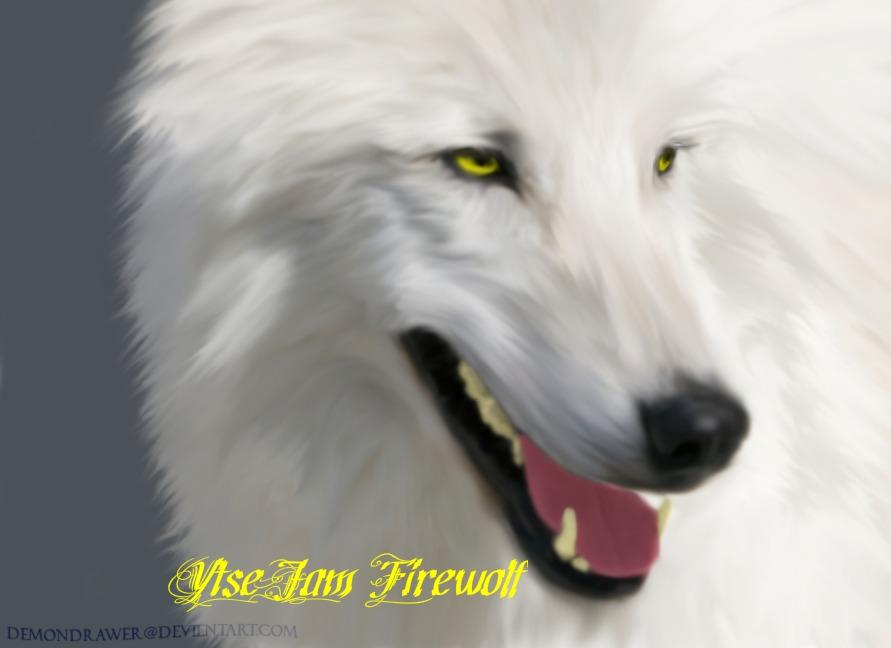

In [56]:
text_search("a full white dog")

Great! It's working pretty well, except for the 4th image, which probably included the background into the embedding. But for now, it's good enough. You can always play around with this notebook and try to improve the results, but I hope you learned how to use multimodal search with OpenAI's Clip model!